In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.fftpack as fft
from scipy.fftpack import dct
import librosa

In [33]:
def calc_plot_mfe_features(audio,
                             sample_rate,
                             alpha = 0.97,
                             NFFT=256,
                             low_freq_cut=80,
                             nfilt=41,
                             noise_floor_dB=-64,
                             frame_size=0.08,
                             frame_stride=0.025,
                             figsize=(10, 5),
                             title= 'MFE',
                             audio_duration=6  # Duration of the audio in seconds
                             ):

    # Pre-emphasis
    audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

    # Calculate frame length and frame step (convert from seconds to samples)
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Calculate the total number of frames
    num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

    # Pad audio signal
    pad_audio_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_audio_length - len(audio)))
    pad_audio = np.append(audio, z)

    # Initialize the frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_audio[indices.astype(np.int32, copy=False)]

    # Apply window function (Hamming)
    frames *= np.hamming(frame_length)

    # Perform FFT and calculate power spectrum
    mag_frames = np.absolute(fft.fft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Take only up to (NFFT/2) + 1 elements after the FFT,
    # as those are the unique frequency components for real-valued signals.
    mag_frames = mag_frames[:, :NFFT//2 + 1]
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Apply Mel filter banks
    low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # Apply the noise floor
    filter_banks = np.where(filter_banks > noise_floor_dB, noise_floor_dB, filter_banks)

    # Normalize the Mel Filterbank Energies
    mean = np.mean(filter_banks, axis=0)
    std_dev = np.std(filter_banks, axis=0)
    std_dev[std_dev == 0] = 1e-10
    filter_banks -= mean
    filter_banks /= std_dev

    # Calculate time array for x-axis
    time = np.linspace(0, audio_duration, num_frames)

    return filter_banks

In [34]:
No_rain, sample_rate = librosa.load('Audios/No.wav', sr=16000,duration=6)
Low_rain, sample_rate = librosa.load('Audios/Low.wav', sr=16000,duration=6)
Medium_rain, sample_rate = librosa.load('Audios/Medium.wav', sr=16000,duration=6)
High_rain, sample_rate = librosa.load('Audios/High.wav', sr=16000,duration=6)

In [35]:
no_rain = calc_plot_mfe_features(No_rain,
                        sample_rate,
                        alpha = 0.97,
                        NFFT=256,
                        low_freq_cut=80,
                        nfilt=41,
                        noise_floor_dB=-64,
                        frame_size=0.08,
                        frame_stride=0.025,
                        figsize = (8,4),
                        title= 'No rain'
                    )

low_rain = calc_plot_mfe_features(Low_rain,
                         sample_rate,
                         alpha = 0.97,
                         NFFT=256,
                         low_freq_cut=80,
                         nfilt=41,
                         noise_floor_dB=-64,
                         frame_size=0.08,
                         frame_stride=0.025,
                         figsize = (8,4),
                         title= 'Low rain'
                         )

medium_rain = calc_plot_mfe_features(Medium_rain,
                         sample_rate,
                         alpha = 0.97,
                         NFFT=256,
                         low_freq_cut=80,
                         nfilt=41,
                         noise_floor_dB=-64,
                         frame_size=0.08,
                         frame_stride=0.025,
                         figsize = (8,4),
                         title= 'Medium rain'
                         )

high_rain = calc_plot_mfe_features(High_rain,
                         sample_rate,
                         alpha = 0.97,
                         NFFT=256,
                         low_freq_cut=80,
                         nfilt=41,
                         noise_floor_dB=-64,
                         frame_size=0.08,
                         frame_stride=0.025,
                         figsize = (8,4),
                         title= 'High rain'
                         )
     

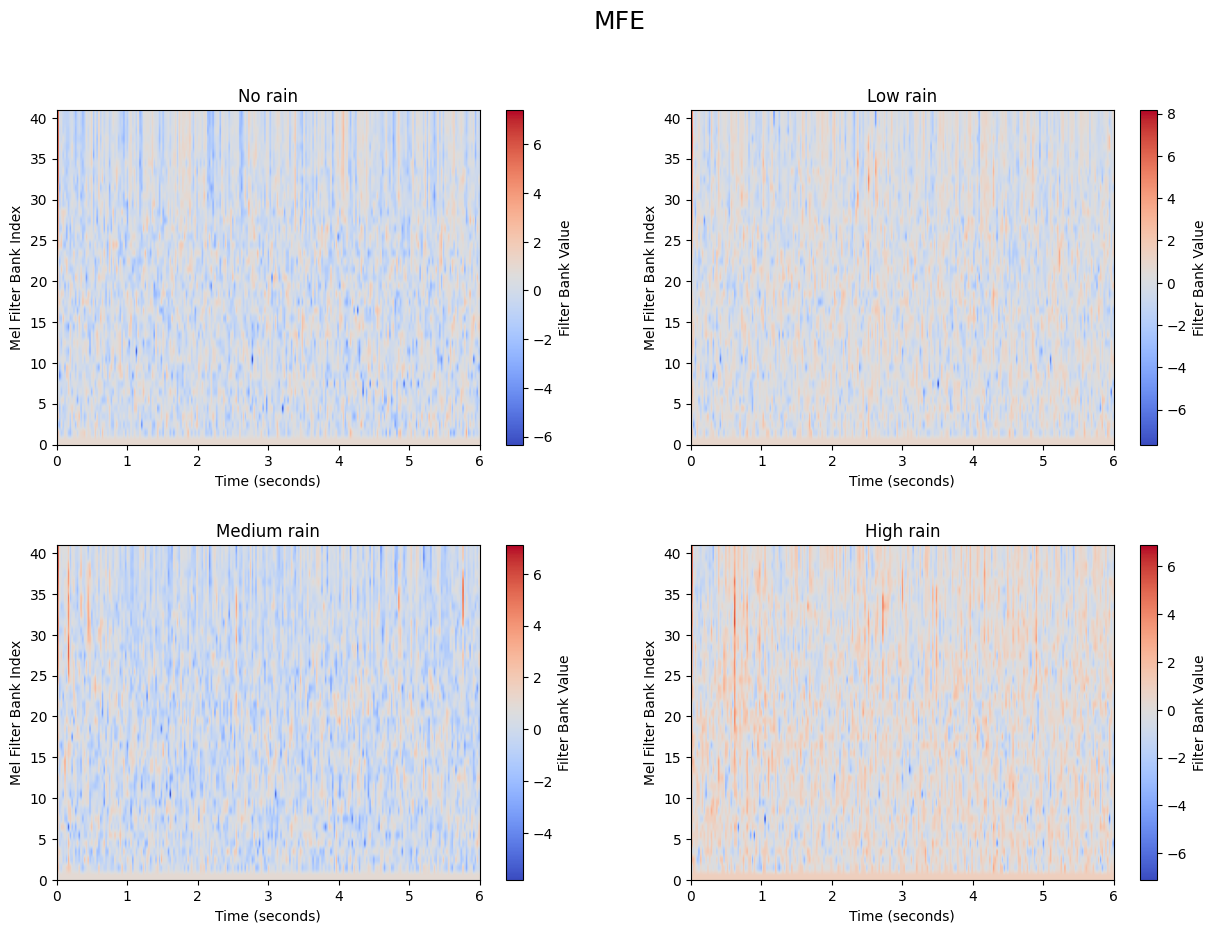

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
fig.suptitle('MFE', fontsize=18)

# Plot data on each subplot and add colorbars
cax0 = axs[0, 0].imshow(no_rain.T, aspect='auto', cmap='coolwarm', origin='lower', extent=[0, 6, 0, 41])
axs[0, 0].set_title('No rain')
fig.colorbar(cax0, ax=axs[0, 0], label='Filter Bank Value')

cax1 = axs[0, 1].imshow(low_rain.T, aspect='auto', cmap='coolwarm', origin='lower', extent=[0, 6, 0, 41])
axs[0, 1].set_title('Low rain')
fig.colorbar(cax1, ax=axs[0, 1], label='Filter Bank Value')

cax2 = axs[1, 0].imshow(medium_rain.T, aspect='auto', cmap='coolwarm', origin='lower', extent=[0, 6, 0, 41])
axs[1, 0].set_title('Medium rain')
fig.colorbar(cax2, ax=axs[1, 0], label='Filter Bank Value')

cax3 = axs[1, 1].imshow(high_rain.T, aspect='auto', cmap='coolwarm', origin='lower', extent=[0, 6, 0, 41])
axs[1, 1].set_title('High rain')
fig.colorbar(cax3, ax=axs[1, 1], label='Filter Bank Value')

# Set labels for each subplot
for ax in axs.flat:
    ax.set(xlabel='Time (seconds)', ylabel='Mel Filter Bank Index')

plt.show()
